# Video Classification with UniFormerV2


In this notebook, we will show how to fine-tune [**UniFormerV2**](https://arxiv.org/abs/2211.09552) model for a classification task. The official release is in [`torch`](https://github.com/OpenGVLab/UniFormerV2). This notebook is the [`keras`](https://github.com/innat/UniFormerV2) reimplementation.


## UniFormerV2

**UniFormerV2**, a generic paradigm to build a powerful family of video networks, by arming the pre-trained ViTs with efficient UniFormer designs. It gets the state-of-the-art recognition performance on 8 popular video benchmarks, including scene-related Kinetics-400/600/700 and Moments in Time, temporal-related Something-Something V1/V2, untrimmed ActivityNet and HACS. In particular, **it is the first model to achieve 90% top-1 accuracy on Kinetics-400**.

In this quick demonstration, we will show how to fine-tune a custom dataset with **UniFormerV2** models. We will be using a uniformerv2 as a backbone and add a custom head on top of it.

<td>
<a target="_blank" href="https://colab.research.google.com/drive/1Z6RzLcno_eLGD_E96mlWoyGieGbKxPQr?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>

<td>
<a target="_blank" href="https://huggingface.co/spaces/innat/UniFormerV2"><img src="https://user-images.githubusercontent.com/17668390/176064420-46cbf547-0d17-4438-a791-d23e17eff5a9.png" />Try on Gradio</a>
</td>

## Dataset

This is where you can use your own data. For demonstration purpose, we have created a sub-set of Kintetics dataset with `5` categories to represent a custom dataset. Here is the link of [KineticsTop5](https://huggingface.co/datasets/innat/KineticsTop5) datast. You can choose your own dataset and dataloader.





In [ ]:
!pip install huggingface_hub decord -q

In [ ]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader

from huggingface_hub import hf_hub_download
from mpl_toolkits.axes_grid1 import ImageGrid
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

DEVICE = 'GPU' # 'GPU', 'TPU'

In [ ]:
if DEVICE == 'TPU':
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu="local")
    strategy = tf.distribute.TPUStrategy(tpu)
    keras.mixed_precision.set_global_policy("mixed_bfloat16")
else:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    [tf.config.experimental.set_memory_growth(pd, True) for pd in physical_devices]
    strategy = tf.distribute.MirroredStrategy()

HOME = os.getcwd()
tf.__version__, HOME, strategy

('2.12.0',
 '/kaggle/working',
 <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy at 0x7a4eeb66b3a0>)

## Utils

In [ ]:
def denormalize(z):
    mean = np.array([0.485, 0.456, 0.406])
    variance = np.array([np.square(0.225), np.square(0.225), np.square(0.225)])
    std = np.sqrt(variance)
    x = (z * std) + mean
    x = x * 255
    return x.clip(0, 255)

def show_sequence(seq, sample=8, title=''):
    '''Plot a sequence of images horizontally'''
    # clip is [T, H, W, 3]
    assert (seq.shape[-1] == 3)
    fig = plt.figure(figsize=(20, 2.5))
    fig.suptitle(title, fontsize=16)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, sample), axes_pad=0.1)
    for ax, img in zip(grid, denormalize(seq)):
        ax.imshow(img.astype('uint8'))
        ax.set_axis_off()
    plt.show()
    return

## Data



In [ ]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

/kaggle/working
/kaggle/working/data


In [ ]:
hf_dataset_identifier = "innat/KineticsTop5"
filename = "kinetics_top5.zip" if DEVICE == 'TPU' else "kinetics_top5_tiny.zip"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)
!unzip -q {file_path}

In [ ]:
train_set = f'{HOME}/data/train'
test_set = f'{HOME}/data/test'
class_folders = os.listdir(train_set)
label2id = {label:i for i, label in enumerate(class_folders)}
id2label = {v:k for k, v in label2id.items()}
id2label

{0: 'opening_bottle',
 1: 'squat',
 2: 'reading_book',
 3: 'reading_newspaper',
 4: 'sneezing'}

In [ ]:
def create_dataframe(path):
    data = []

    for class_name in os.listdir(path):
        class_dir = os.path.join(path, class_name)
        if os.path.isdir(class_dir) and class_name in label2id:
            for video_file in os.listdir(class_dir):
                video_path = os.path.join(class_dir, video_file)
                data.append({
                    'video_path': os.path.abspath(video_path),
                    'label': label2id[class_name],
                    'class_name': class_name
                })

    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_df = create_dataframe(train_set)
test_df = create_dataframe(test_set)
train_df.shape, test_df.shape

((1006, 3), (243, 3))

In [ ]:
test_df.head()

,video_path,label,class_name
0,/kaggle/working/data/test/sneezing/gA4C_6xvxmw...,4,sneezing
1,/kaggle/working/data/test/reading_newspaper/cX...,3,reading_newspaper
2,/kaggle/working/data/test/reading_newspaper/26...,3,reading_newspaper
3,/kaggle/working/data/test/opening_bottle/2PZhu...,0,opening_bottle
4,/kaggle/working/data/test/squat/PD0U0AEqTbE.mp4,1,squat


# Data Loader

Reading the video data from dataloader in training time can be challenging. We can leverage [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) format, but due to the cost of disk space, we will skip that. For now, we will be using [`decord`](https://github.com/dmlc/decord) for video reader. It supports both GPUs and TPUs.



In [ ]:
input_size=224
num_frame=8
sampling_rate=16
batch_size=4 * strategy.num_replicas_in_sync

In [ ]:
def read_video(file_path):
    vr = VideoReader(file_path.numpy().decode('utf-8'))
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(
        frames,
        output_size=(input_size, input_size)
    )

def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.uint8)
    frame = tf.image.resize(frame, size=list(output_size))
    return frame

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([None, None, None, 3])
    return video, tf.cast(label, dtype=tf.float32)

The raw **Kinetics** data comes with variable size of **input frame** and **frame size**. We will resize the video to the target shape (i.e. `224`). For **UniFormerV2** model, the clip length can be `8`, `16`, `32`, and `64`; we will be using `8`. The frame rate in **UniFormerV2** is `16` which is the stride or step from a frame to next frame. We will also take `1` clip from a video. However, in literature for evaluation, it's common to take `num_clips > 1` from each clip and average the results for final prediction For **UniFormerV2**, check a [note](https://github.com/innat/UniFormerV2/blob/main/MODEL_ZOO.md#model-zoo) on this. Here, for simplicity cause, we will skip that.


Sampling strategy for frame selection is another important factor which might need another attention. It can significantly differs the reported scores. In this notebook, we will be using [uniform sampling](https://gist.github.com/innat/205075992360d8d7a241c7f1013866a8) for frame selection.

In [ ]:
def uniform_temporal_subsample(
    x, num_samples, clip_idx, total_clips, frame_rate=1, temporal_dim=-4
):
    t = tf.shape(x)[temporal_dim]
    max_offset = t - num_samples * frame_rate
    step = max_offset // total_clips
    offset = clip_idx * step
    indices = tf.linspace(
        tf.cast(offset, tf.float32),
        tf.cast(offset + (num_samples-1) * frame_rate, tf.float32),
        num_samples
    )
    indices = tf.clip_by_value(indices, 0, tf.cast(t - 1, tf.float32))
    indices = tf.cast(tf.round(indices), tf.int32)
    return tf.gather(x, indices, axis=temporal_dim)


def clip_generator(
    image, num_frames=32, frame_rate=1, num_clips=1, crop_size=224
):
    clips_list = []
    for i in range(num_clips):
        frame = uniform_temporal_subsample(
            image, num_frames, i, num_clips, frame_rate=frame_rate, temporal_dim=0
        )
        clips_list.append(frame)

    video = tf.stack(clips_list)
    video = tf.reshape(
        video, [num_clips*num_frames, crop_size, crop_size, 3]
    )
    return video


In [ ]:
processing_model = keras.Sequential(
    [
        layers.Rescaling(scale=1./255.),
        layers.Normalization(
            mean=[0.485, 0.456, 0.406],
            variance=[np.square(0.225), np.square(0.225), np.square(0.225)]
        )
    ]
)

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (df['video_path'].values, df['label'].values)
    )
    ds = ds.repeat()
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(
        lambda x, y: (clip_generator(x, num_frame, sampling_rate, num_clips=1), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.map(lambda x, y: (processing_model(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
train_ds = create_dataloader(
    train_df, batch_size, shuffle=True
)

test_ds = create_dataloader(
    test_df, batch_size, shuffle=False
)

**Visualize**

In [ ]:
temp_ds = create_dataloader(
    test_df, 8, shuffle=False
)
x, y = next(iter(temp_ds))
x.shape, y

(TensorShape([8, 8, 224, 224, 3]),
 <tf.Tensor: shape=(8,), dtype=float32, numpy=array([4., 3., 3., 0., 1., 3., 1., 1.], dtype=float32)>)

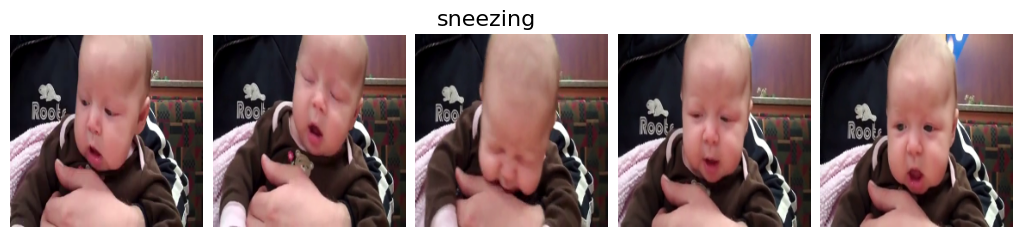

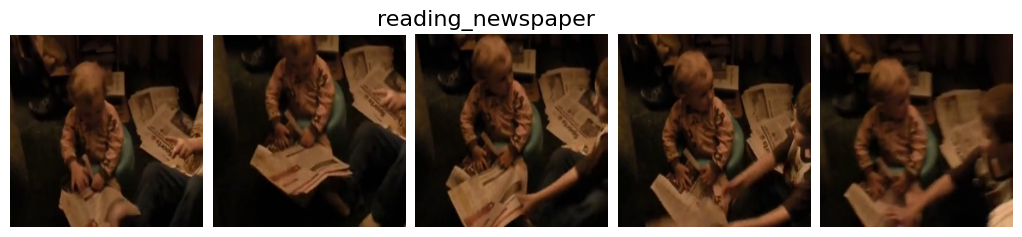

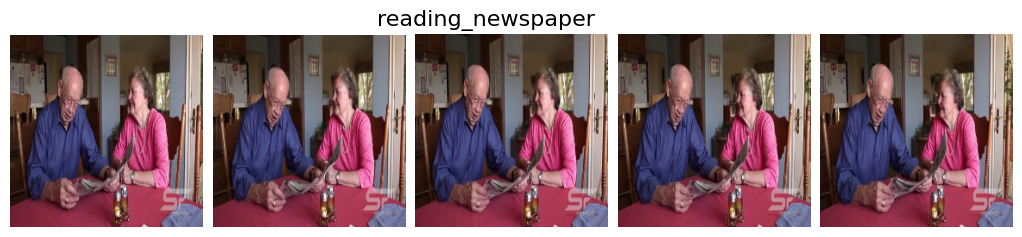

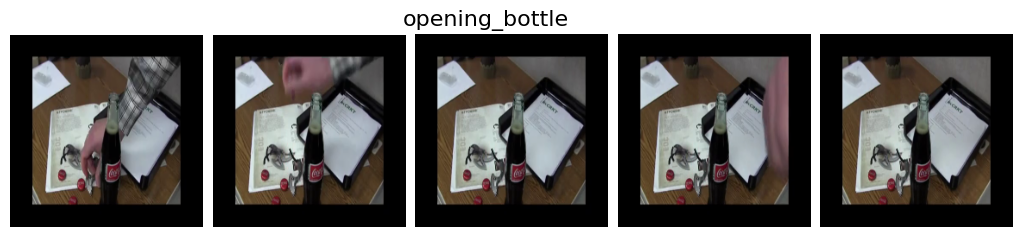

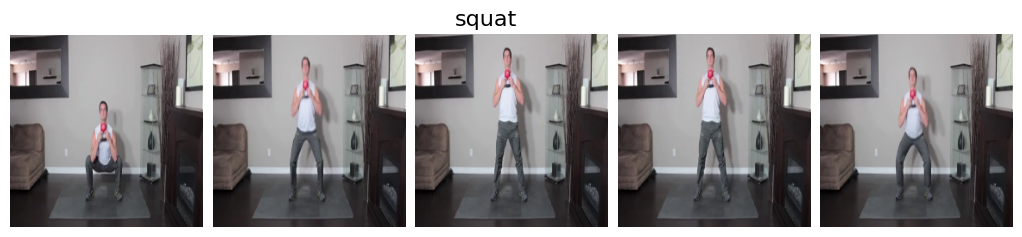

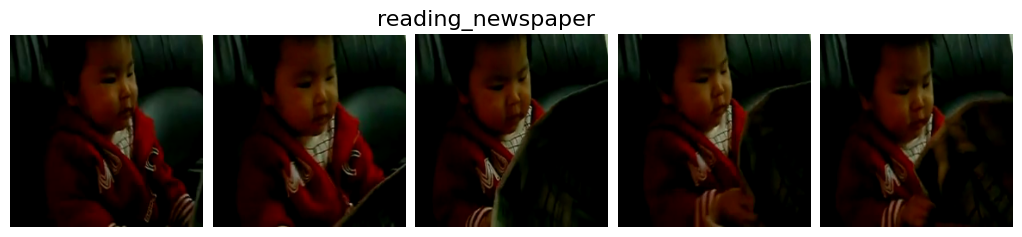

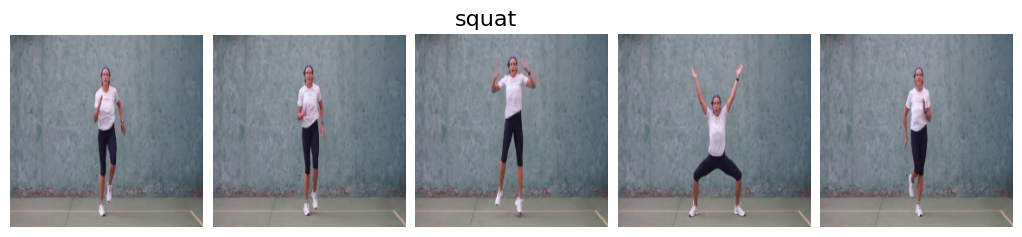

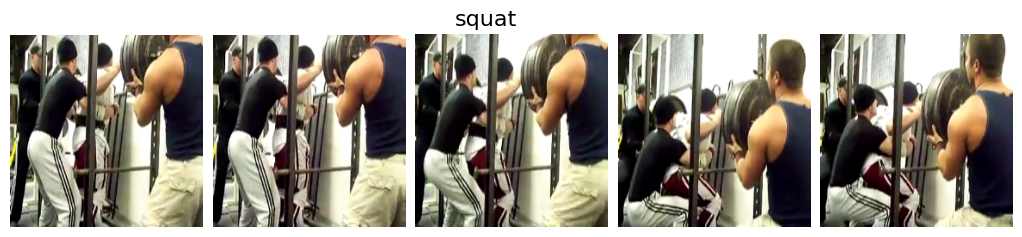

In [ ]:
for i in range(len(x)):
    show_sequence(
        x.numpy()[i], sample=5, title=id2label[y[i].numpy()]
    )

# Model

As mentioned, we are using a custom **Kinetics-5** dataset. We will be using **UniFormerV2** model with [**Moments in Time**](http://moments.csail.mit.edu/) pretrained checkpoint. We will freeze the backbone and only train the custom head for downstream task.

In [ ]:
backbone_name = "TFUniFormerV2_MITV1_K710_K400_B16_8x224"

In [ ]:
!wget 'https://github.com/innat/UniFormerV2/releases/download/v1.0/{backbone_name}.zip'
!unzip -q '/content/{backbone_name}.zip'

In [ ]:
with strategy.scope():
    # fine-tuned model on kinetics-top5
    finetune_uniformerv2 = keras.models.load_model(
        f'/content/data/{backbone_name}', compile=False
    )
    finetune_uniformerv2.trainable = False

    # downstream model
    model = keras.Sequential([
        finetune_uniformerv2,
        layers.Dense(
            len(class_folders), dtype='float32', activation=None
        )
    ])

    # compile the model
    model.compile(
        optimizer=keras.optimizers.AdamW(
          learning_rate=1e-3,
          weight_decay=1e-4
        ),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
          keras.metrics.SparseCategoricalAccuracy(name='acc@1'),
          keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="acc@3")
        ]
    )

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    steps_per_epoch=len(train_df) // batch_size,
    validation_steps=len(test_df) // batch_size,
    epochs=5,
)

Epoch 1/5
251/251 [==============================] - 397s 1s/step - loss: 1.0357 - acc@1: 0.6305 - acc@3: 0.9074 - val_loss: 0.4196 - val_acc@1: 0.8292 - val_acc@3: 0.9875
Epoch 2/5
251/251 [==============================] - 364s 1s/step - loss: 0.6351 - acc@1: 0.7620 - acc@3: 0.9671 - val_loss: 0.3006 - val_acc@1: 0.9000 - val_acc@3: 0.9875
Epoch 3/5
251/251 [==============================] - 362s 1s/step - loss: 0.4884 - acc@1: 0.8217 - acc@3: 0.9791 - val_loss: 0.2538 - val_acc@1: 0.9125 - val_acc@3: 0.9875
Epoch 4/5
251/251 [==============================] - 371s 1s/step - loss: 0.4814 - acc@1: 0.8167 - acc@3: 0.9801 - val_loss: 0.2435 - val_acc@1: 0.9125 - val_acc@3: 0.9917
Epoch 5/5
251/251 [==============================] - 382s 2s/step - loss: 0.4413 - acc@1: 0.8426 - acc@3: 0.9791 - val_loss: 0.2209 - val_acc@1: 0.9167 - val_acc@3: 0.9917


# Inference

In [ ]:
test_sample = 'opening_bottle/0npur3PQMHA.mp4' #@param ["opening_bottle/0npur3PQMHA.mp4", "reading_newspaper/26N2XO29YU8.mp4", "reading_book/BFYBAg9fSL4.mp4", "sneezing/6k-Uob0qzW4.mp4", "squat/6_jT33BqtK8.mp4"]

In [ ]:
def read_video(file_path):
    vr = VideoReader(file_path)
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(
        frames,
        output_size=(input_size, input_size)
    )

def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.uint8)
    frame = tf.image.resize(frame, size=list(output_size))
    return frame

sample_ds = read_video(os.path.join('/kaggle/working/data/test', test_sample))
sample_ds = clip_generator(sample_ds, num_frame, sampling_rate, num_clips=1)
sample_ds = processing_model(sample_ds)
sample_ds.shape

TensorShape([1, 8, 224, 224, 3])

In [ ]:
y_pred = model(sample_ds, training=False)
y_pred = y_pred.numpy().argmax(-1)[0]
y_pred

0

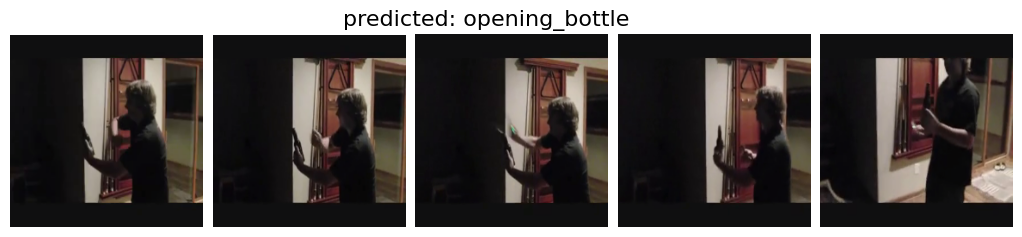

In [ ]:
show_sequence(
    sample_ds.numpy().squeeze(), sample=5, title='predicted: ' + str(id2label[y_pred])
)